# Analyze grid extension cost estimation raw data

## Read and process data

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

cost = pd.read_csv('data/costs.csv', comment='#', index_col='grid')
faulty_grids = pd.read_csv('data/faulty_grids.csv', index_col='grid')
cost_before = pd.read_csv('data/costs_before_generators.csv', comment='#', index_col='grid')
faulty_grids_before = pd.read_csv('data/faulty_grids_before_generators.csv', index_col='grid')
attributes = pd.read_csv('data/ding0_grids__0_to_3608_mv_stats.csv', index_col='grid_id')
future_res_capacity = pd.read_csv('data/RES_powerplants-diff_of_count_and_cap-StatusQuo-NEP2035.csv', index_col='hv_mv_subst_id', delimiter=';')

# cumulative cost in each grid: before and after generators import
cumulative_cost = cost.groupby('grid').sum()
cumulative_cost_before = cost.groupby('grid').sum()

# join all data sources to a single dataframe
attributes.index.set_names('grid', inplace=True)
future_res_capacity.index.set_names('grid', inplace=True)


#cost_data = pd.concat([cost, cost_before['total_costs'].to_frame('total_costs_before')], axis=1)
cost_data = pd.merge(cost, cost_before['total_costs'].to_frame('total_costs_before'), left_index=True, right_index=True, how='outer')
faulty_data = pd.merge(faulty_grids, faulty_grids_before['msg'].to_frame('msg_before'), left_index=True, right_index=True, how='outer')

all_data = pd.merge(attributes, cost_data, left_index=True, right_index=True)
all_data = pd.merge(all_data, faulty_data, left_index=True, right_index=True)

all_data['solar_2035'] = future_res_capacity.loc[future_res_capacity['generation_type'] == 'solar']['capacity_diff_kw']
all_data['wind_2035'] = future_res_capacity.loc[future_res_capacity['generation_type'] == 'wind']['capacity_diff_kw']
all_data['solar_2015'] = all_data['Gen. Cap. of MV solar/solar_ground_mounted'] + all_data['Gen. Cap. of MV solar/solar_roof_mounted']
all_data['Length cable/lines MV'] = all_data['Length of MV underground cables'] + all_data['Length of MV overhead lines']
all_data['Length cable/lines LV'] = all_data['Length of LV underground cables'] + all_data['Length of LV overhead lines']

## Number of grids and missing data

In [4]:
data_info = pd.Series({'grid_range': (min(list(cost.index.values) + list(attributes.index.values)),
                                      max(list(cost.index.values) + list(attributes.index.values))),
                       'grids_dingo': len(attributes),
                       'grids_reinforced_b_gens': len(cumulative_cost_before),
                       'grids_reinforced_a_gens': len(cumulative_cost),
                       'grids_w_issue_b_gens': len(cumulative_cost_before.loc[cumulative_cost_before.index.isin(list(faulty_grids_before.index.values))]),
                       'grids_w_issue_a_gens': len(cumulative_cost.loc[cumulative_cost.index.isin(list(faulty_grids.index.values))])})
print(data_info)

print('\nAverage grid extension cost based on {number} grids: {cost:.0f} million EUR'.format(
        number=len(cumulative_cost), cost=cumulative_cost['total_costs'].mean() / 1e3))
print('Total grid extension cost (scaled to 3608 grids) add up to: {total:.0f} million EUR'.format(total=cumulative_cost['total_costs'].mean() / 1e3 * 3608))

grid_range                 (1, 3608)
grids_dingo                     3402
grids_reinforced_a_gens         3186
grids_reinforced_b_gens         3186
grids_w_issue_a_gens             518
grids_w_issue_b_gens             142
dtype: object

Average grid extension cost based on 3186 grids: 6 million EUR
Total grid extension cost (scaled to 3608 grids) add up to: 21542 million EUR


### Validity and correlations

(0, 50000)

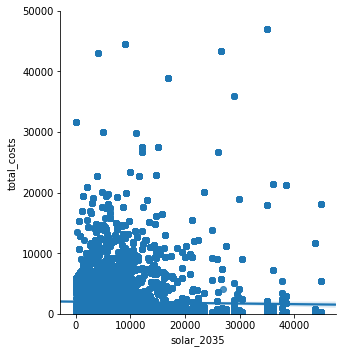

In [5]:
import seaborn as sns

sns.lmplot(x="solar_2035", y="total_costs", data=all_data, fit_reg=True)
plt.ylim([0, 50000])

(0, 50000)

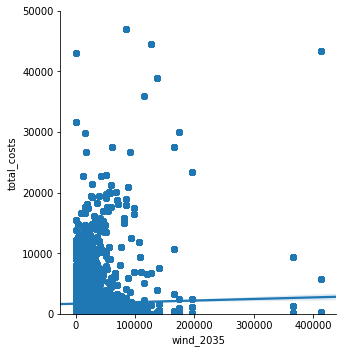

In [6]:
sns.lmplot(x="wind_2035", y="total_costs", data=all_data)
plt.ylim([0, 50000])

(0, 50000)

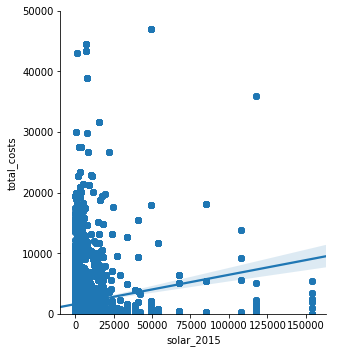

In [7]:
sns.lmplot(x="solar_2015", y="total_costs", data=all_data)
plt.ylim([0, 50000])

(0, 50000)

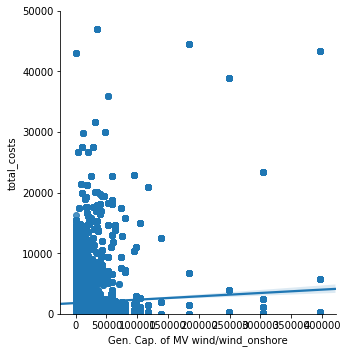

In [8]:
sns.lmplot(x='Gen. Cap. of MV wind/wind_onshore', y="total_costs", data=all_data)
plt.ylim([0, 50000])

(0, 50000)

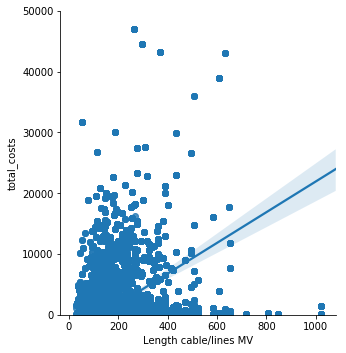

In [9]:
sns.lmplot(x='Length cable/lines MV', y="total_costs", data=all_data)
plt.ylim([0, 50000])

(0, 50000)

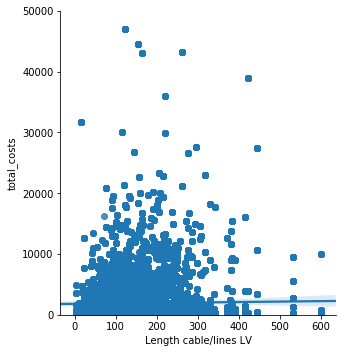

In [10]:
sns.lmplot(x='Length cable/lines LV', y="total_costs", data=all_data)
plt.ylim([0, 50000])